<a href="https://colab.research.google.com/github/AlexandreMinato/Investimentos_FII/blob/main/Analises_FII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime


#Capturando informacões
Capturando as informações do fundsexplorer para iniciar a analise. São 2 etapas:

1.   Informações gerais dos fundos imobiliarios
2.   Informações sobre pagamentos de variação de dividendos, oscilação, minimo, maximo e etc

O objetivo desta analise é encontrar fundos que pague dividendos sem muita oscilação, fundos com diversificação em seus ativos, que tenha liquidez e que tenha um valor justo (cota x valor patrimonial) adequado para compra

## 1) Informações gerais dos fundos imobiliarios - capturando informações

In [ ]:
url = 'https://www.fundsexplorer.com.br/ranking'
dados = requests.get(url,  headers={'User-Agent': 'Mozilla/5.0'})
list_obj = pd.read_html(dados.text, attrs={'id': 'table-ranking'})
df = list_obj[0]

In [ ]:
# redefinindo nome das colunas
df.columns = ['ativo', 'setor', 'preco', 'liquidez_dia', 'dividendo', 'yeld', 'yeld_3m_acululado', 'yeld_6m_acululado', 'yeld_12m_acululado', 'yeld_3m_media', 'yeld_6m_media', 'yeld_12m_media', 'yeld_ano', 'variacao_preco', 'rent_periodo', 'rent_acumulada', 'patrimonio_liq', 'vpa', 'p_vpa', 'dy_patrimonial', 'variacao_patrimonial', 'rent_patr_periodo', 'rent_acumulada_periodo', 'vacancia_fisica', 'vacancia_financeira', 'quantidade_ativos']

In [ ]:
df.head()

,ativo,setor,preco,liquidez_dia,dividendo,yeld,yeld_3m_acululado,yeld_6m_acululado,yeld_12m_acululado,yeld_3m_media,yeld_6m_media,yeld_12m_media,yeld_ano,variacao_preco,rent_periodo,rent_acumulada,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos
0,FIVN11,Shoppings,"R$ 3,09",31730.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%",NaN,"0,00%","0,00%","0,00%","R$ 64.832.865,32","R$ 6,89",45.0,NaN,NaN,NaN,NaN,"56,00%",NaN,1
1,BZLI11,Títulos e Val. Mob.,"R$ 14,70",44041.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,68%","0,68%","1,14%","R$ 439.665.897,40","R$ 11,45",128.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,XTED11,Lajes Corporativas,"R$ 6,88",993.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","1,10%","1,10%","-37,83%","R$ 25.472.636,57","R$ 14,21",48.0,NaN,NaN,NaN,NaN,"0,00%","100,00%",1
3,ALMI11,Lajes Corporativas,"R$ 1.180,00",31.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","2,27%","2,27%","-28,29%","R$ 229.423.903,28","R$ 2.063,59",57.0,NaN,NaN,NaN,NaN,"68,15%",NaN,1
4,DOMC11,Lajes Corporativas,"R$ 439,00",42.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","0,00%","4,35%","4,35%","-10,00%","R$ 264.351.778,61","R$ 108,17",406.0,NaN,NaN,NaN,NaN,"23,44%",NaN,1


###Normalizando as colunas



In [ ]:
def identificar_conteudo_colunas(df, item):
    
    return [df[column].name for column in df if df[column].astype(str).str.contains(item).any()]

In [ ]:
#Converter financeiro
coluna_monetario = identificar_conteudo_colunas(df, '\$')

for column_name in coluna_monetario:
    df[column_name] = df[column_name].str.replace('.', '')
    df[column_name] = df[column_name].str.replace(',', '.')
    df[column_name] = df[column_name].str.replace('[R\$ ,]', '', regex=True).astype(float)

In [ ]:
# Converter as colunas de percentual em numericas
coluna_percentual = identificar_conteudo_colunas(df, '\%')
for column_name in coluna_percentual:
    df[column_name] = df[column_name].str.replace(',', '.')
    df[column_name] = df[column_name].str.replace('[%,]', '', regex=True).astype(float)
    df[column_name] = df[column_name]/100

In [ ]:
# Normaliza o setor
df['setor'] = df['setor'].str.replace('\s+', '_')
df['setor'] = df['setor'].str.replace(r'[^\w\s]+', '_')
df['setor'] = df['setor'].str.lower()
df['setor'] = df['setor'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

## Iniciando as analises


In [ ]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'outros', 'hotel', 'residencial', 'logistica',
       'hospital'], dtype=object)

In [ ]:
df.ativo.nunique()

238

In [104]:
# Corrigindo o valor patrimonial por acao
df['p_vpa'] = df['p_vpa']/100

In [ ]:
df.describe()

,preco,liquidez_dia,dividendo,yeld,yeld_3m_acululado,yeld_6m_acululado,yeld_12m_acululado,yeld_3m_media,yeld_6m_media,yeld_12m_media,yeld_ano,variacao_preco,rent_periodo,rent_acumulada,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos
count,228.000000,2.280000e+02,238.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,213.000000,223.000000,223.000000,223.000000,2.380000e+02,238.000000,228.00,4.000000,4.000000,4.000000,4.000000,116.000000,25.000000,238.000000
mean,519.575088,2.267750e+04,1.316261,0.007762,0.018336,0.032259,0.051758,0.006113,0.005376,0.004315,0.026166,-0.014350,-0.007016,-0.030787,5.149004e+08,662.396429,inf,0.006950,0.002075,0.009000,0.022475,0.155532,0.126372,3.331933
std,5642.306143,1.006695e+05,4.445995,0.024733,0.027136,0.033717,0.051927,0.009043,0.005621,0.004328,0.030311,0.103246,0.103179,0.124369,7.104465e+08,6211.667336,NaN,0.001109,0.003292,0.003562,0.004882,0.228208,0.232114,7.999150
min,0.780000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.946500,-0.946200,-0.945900,-5.574880e+06,-7.350000,-1.72,0.005900,0.000100,0.006500,0.016200,0.000000,0.000000,0.000000
25%,82.282500,2.182500e+02,0.400000,0.004100,0.009300,0.015850,0.000000,0.003100,0.002650,0.000000,0.016100,-0.022650,-0.016050,-0.050800,1.030673e+08,93.750000,0.84,0.006200,0.000475,0.006800,0.019875,0.000000,0.000000,0.000000
50%,99.120000,2.483000e+03,0.630000,0.006100,0.016800,0.032500,0.055800,0.005600,0.005400,0.004600,0.022500,-0.000200,0.000500,-0.009900,2.621177e+08,99.915000,0.97,0.006750,0.000600,0.007650,0.023350,0.057350,0.036000,1.000000
75%,111.545000,1.481425e+04,0.900000,0.007700,0.022400,0.043800,0.077200,0.007450,0.007300,0.006400,0.030100,0.013250,0.019000,0.024550,5.922617e+08,109.795000,1.04,0.007500,0.002200,0.009850,0.025950,0.211000,0.123000,3.000000
max,85227.760000,1.336487e+06,52.740000,0.363200,0.379900,0.409600,0.452200,0.126600,0.068300,0.037700,0.392400,0.327300,0.330300,0.410700,4.852707e+09,93717.970000,inf,0.008400,0.007000,0.014200,0.027000,1.000000,1.000000,72.000000


In [ ]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'outros', 'hotel', 'residencial', 'logistica',
       'hospital'], dtype=object)

In [105]:
# filtrando setores que eu gosto
df = df[df['setor'].isin(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas', 'hibrido', 'logistica'])].copy()

In [106]:
df.setor.unique()

array(['shoppings', 'titulos_e_val__mob_', 'lajes_corporativas',
       'hibrido', 'logistica'], dtype=object)

###Condicoes para filtrar os FIIs

In [ ]:
#Preco aceitavel para pagamento, considerando cota e valor patrimonial
df['preco_justo'] = np.where((df['p_vpa'] > 0.9) & (df['p_vpa'] < 1.1) , True, False)

setores_considerar = ['shoppings', 'lajes_corporativas', 'logistica']

# Criando filtros
diversificacoes_ativos = [
    # Condicoes de setores que gosto com mais de 5 ativos
    (df['setor'].isin(setores_considerar)) & 
    (df['quantidade_ativos'] > 5),
    # Condicoes de setores que gosto com menos de 5 ativos (inativo na hora de aplicar o filtro, deixei aqui, caso queira olhar para fundos com pouca diversificação, bastante alterar a variavel diversificacoes_aceitaveis para True, True, True)
    (df['setor'].isin(setores_considerar)) &
    (df['quantidade_ativos'] < 5),
    # setores
    (~df['setor'].isin(setores_considerar))
]
#Aplicacao dos filtros
diversificacoes_aceitaveis = [True, False, True]
df['ativos_diversificados'] = np.select(diversificacoes_ativos, diversificacoes_aceitaveis, default=None)

# imovel com vacancia aceitavel
df['vacancia_aceitavel'] = np.where((df['vacancia_fisica'] < 0.1) | (df['vacancia_fisica'].isnull()) | (df['vacancia_fisica'].isnull()) , True, False)

# Fundo que tenham liquidez
df['liquidez'] = np.where(df['liquidez_dia'] > 20000, True, False)

# Fundos que pagam dividendos acima de 0,5%, considerando o acumulado de 12 meses
df['dividendos_minimos'] = np.where(df['yeld_12m_acululado'] > 0.05, True, False)

###Criando as condições dos filtros

In [ ]:

condicoes_ativos = (
    df.preco_justo &
    df.ativos_diversificados &
    df.vacancia_aceitavel &
    df.liquidez &
    df.dividendos_minimos
)
df_results = df.loc[condicoes_ativos].sort_values(by=['yeld_12m_acululado', 'liquidez_dia'], ascending=False)
df_results = df_results.set_index('ativo')

# Analisando os resultados
*Os papéis abaixo atendem aos filtros de diversificação e preço justo.

In [ ]:
df_results

,setor,preco,liquidez_dia,dividendo,yeld,yeld_3m_acululado,yeld_6m_acululado,yeld_12m_acululado,yeld_3m_media,yeld_6m_media,yeld_12m_media,yeld_ano,variacao_preco,rent_periodo,rent_acumulada,patrimonio_liq,vpa,p_vpa,dy_patrimonial,variacao_patrimonial,rent_patr_periodo,rent_acumulada_periodo,vacancia_fisica,vacancia_financeira,quantidade_ativos,preco_justo,ativos_diversificados,vacancia_aceitavel,liquidez,dividendos_minimos
ativo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RECR11,titulos_e_val__mob_,101.40,52859.0,1.10,0.0100,0.0280,0.0673,0.1232,0.0093,0.0112,0.0103,0.0407,0.0084,0.0185,0.0227,1.355698e+09,95.23,1.06,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
CVBI11,titulos_e_val__mob_,104.60,32898.0,1.00,0.0094,0.0287,0.0732,0.1171,0.0096,0.0122,0.0098,0.0402,0.0009,0.0104,0.0211,5.961533e+08,100.08,1.05,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
CPTS11,titulos_e_val__mob_,99.80,103882.0,1.05,0.0104,0.0307,0.0615,0.1064,0.0102,0.0102,0.0089,0.0408,-0.0231,-0.0130,0.0204,1.749247e+09,95.18,1.05,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
BCRI11,titulos_e_val__mob_,115.01,35865.0,1.51,0.0127,0.0316,0.0600,0.1040,0.0105,0.0100,0.0087,0.0392,0.0442,0.0574,0.0473,4.698016e+08,106.77,1.08,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
KNIP11,titulos_e_val__mob_,109.50,49924.0,1.00,0.0088,0.0280,0.0598,0.0945,0.0093,0.0100,0.0079,0.0392,-0.0254,-0.0168,0.0328,4.852707e+09,102.95,1.06,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
KNHY11,titulos_e_val__mob_,111.79,35745.0,1.20,0.0105,0.0313,0.0638,0.0930,0.0104,0.0106,0.0078,0.0439,-0.0020,0.0085,0.0611,1.095864e+09,102.50,1.09,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
MXRF11,hibrido,10.58,1336487.0,0.08,0.0075,0.0226,0.0425,0.0804,0.0075,0.0071,0.0067,0.0301,0.0250,0.0327,0.0344,2.272793e+09,10.02,1.06,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
RBRF11,titulos_e_val__mob_,89.13,24166.0,0.60,0.0065,0.0194,0.0423,0.0798,0.0065,0.0070,0.0066,0.0255,-0.0169,-0.0105,-0.0506,1.257992e+09,91.95,0.97,NaN,NaN,NaN,NaN,NaN,NaN,0,True,True,True,True,True
VINO11,lajes_corporativas,60.66,42512.0,0.45,0.0074,0.0219,0.0414,0.0792,0.0073,0.0069,0.0066,0.0290,-0.0142,-0.0070,-0.0172,7.607044e+08,60.02,1.01,NaN,NaN,NaN,NaN,0.037,NaN,9,True,True,True,True,True


##Simulando valor de investimento para calcular o retorno (forecast)

In [ ]:

valor_investir = 200000
df_results['valor_investir'] = (valor_investir / df_results.preco)
df_results['valor_investir'] = df_results['valor_investir'].astype(int)
df_results['resultado_previsto'] = df_results['valor_investir'].astype(int) * df_results['dividendo'].astype(float)
df_results[['preco', 'dividendo', 'yeld', 'valor_investir', 'resultado_previsto']]

,preco,dividendo,yeld,valor_investir,resultado_previsto
ativo,,,,,
RECR11,101.40,1.10,0.0100,1972,2169.20
CVBI11,104.60,1.00,0.0094,1912,1912.00
CPTS11,99.80,1.05,0.0104,2004,2104.20
BCRI11,115.01,1.51,0.0127,1738,2624.38
KNIP11,109.50,1.00,0.0088,1826,1826.00
KNHY11,111.79,1.20,0.0105,1789,2146.80
MXRF11,10.58,0.08,0.0075,18903,1512.24
RBRF11,89.13,0.60,0.0065,2243,1345.80
VINO11,60.66,0.45,0.0074,3297,1483.65


In [ ]:
titulo = 'Retorno mensal considerando aplicação de : ' + "R$ {:,.2f}". format(valor_investir)

<BarContainer object of 18 artists>

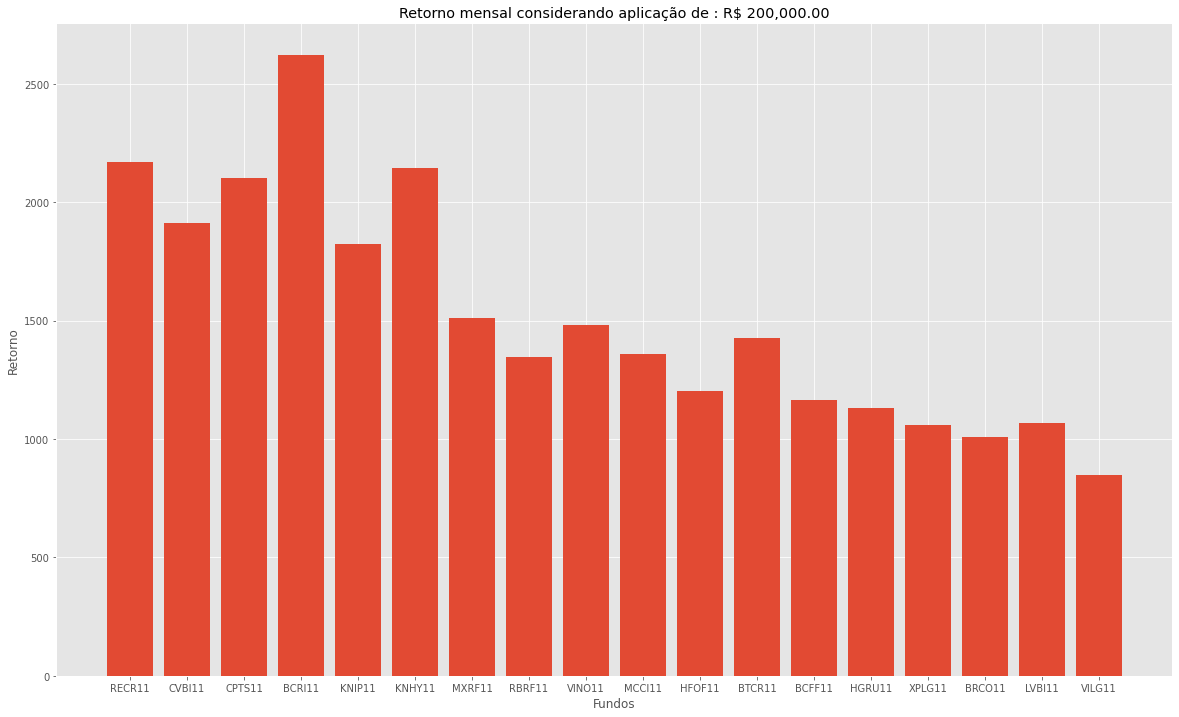

In [ ]:

plt.style.use("ggplot")
plt.figure(figsize = (20, 12))
plt.title(titulo)
plt.xlabel("Fundos")
plt.ylabel("Retorno")
plt.bar(df_results.index, df_results.resultado_previsto)

# Etapa 2: consulta de pagamento dos dividendos mensais de cada fundo

In [ ]:
def capturar_valor_rendimentos(codFII):
  url_rend = 'https://fiis.com.br/' + codFII
  dados_rend = requests.get(url_rend,  headers={'User-Agent': 'Mozilla/5.0'})
  tb_rend = pd.read_html(dados_rend.text, attrs={'id': 'last-revenues--table'})
  df_rend = tb_rend[0]  
  df_rend.columns = ['data_base', 'data_pagamento', 'cotacao_base', 'div_yeld', 'rendimento']  
  df_rend.insert(0,'ativo', codFII)
  df_rend.set_index('ativo')

  coluna_monetario = identificar_conteudo_colunas(df_rend, '\$')
  for column_name in coluna_monetario:
    df_rend[column_name] = df_rend[column_name].str.replace('.', '')
    df_rend[column_name] = df_rend[column_name].str.replace(',', '.')
    df_rend[column_name] = df_rend[column_name].str.replace('[R\$ ,]', '', regex=True).astype(float)

  coluna_percentual = identificar_conteudo_colunas(df_rend, '\%')
  for column_name in coluna_percentual:
    df_rend[column_name] = df_rend[column_name].str.replace(',', '.')
    df_rend[column_name] = df_rend[column_name].str.replace('[%,]', '', regex=True).astype(float)
    df_rend[column_name] = df_rend[column_name]/100

  #Converter colunas de datas
  coluna_data = identificar_conteudo_colunas(df_rend, '\/')
  for column_name in coluna_data:
    df_rend[column_name] = df_rend[column_name].apply(lambda x: datetime.strptime(x, '%d/%m/%y'))
      
  df_result = df_rend.groupby('ativo').agg({'rendimento': ['min','max', 'median', 'var', 'mean', 'quantile']})
  df_result.columns = ['minimo','maximo', 'mediana', 'variacao', 'media', 'quartil']
  return df_result

In [ ]:
df_union = pd.DataFrame(columns=['minimo','maximo', 'mediana', 'variacao', 'media', 'quartil']) 

for ind in df_results.index:
  df_union = df_union.append([capturar_valor_rendimentos(ind)])
  

In [ ]:
 df_union_data = pd.concat([df_union, df_results], axis=1)

# Cruzando informacoes gerais do fundo (vacancia, liquidez e etc) com rendimentos pagos (minimo, maximo, desvio padrao e etc)

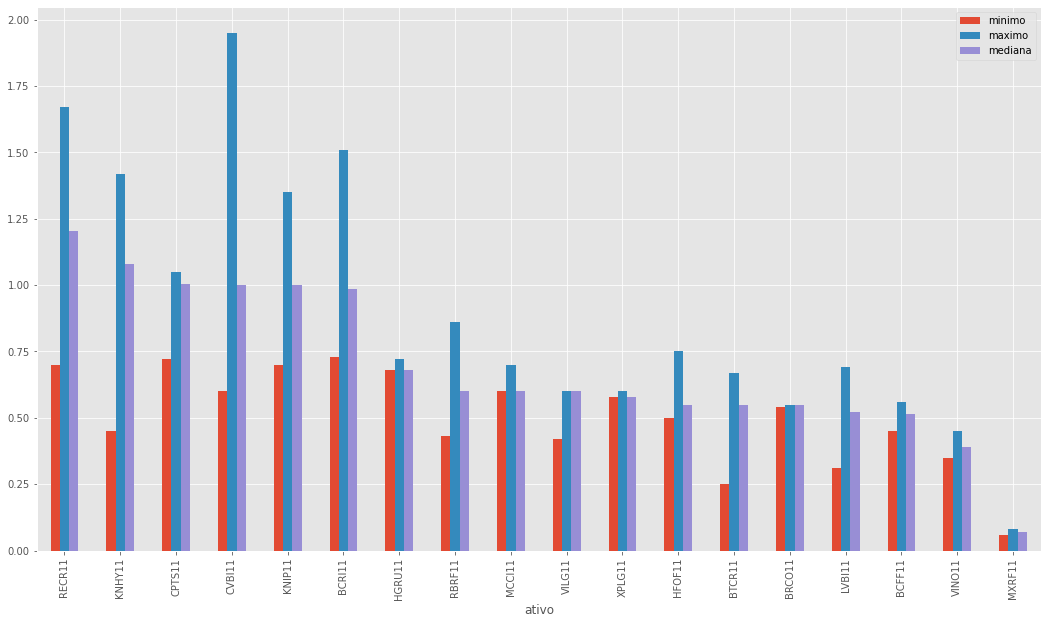

In [ ]:
plt.style.use('ggplot')
df_union_data[['minimo', 'maximo', 'mediana']].plot(figsize = (18, 10), grid=True, kind='bar')

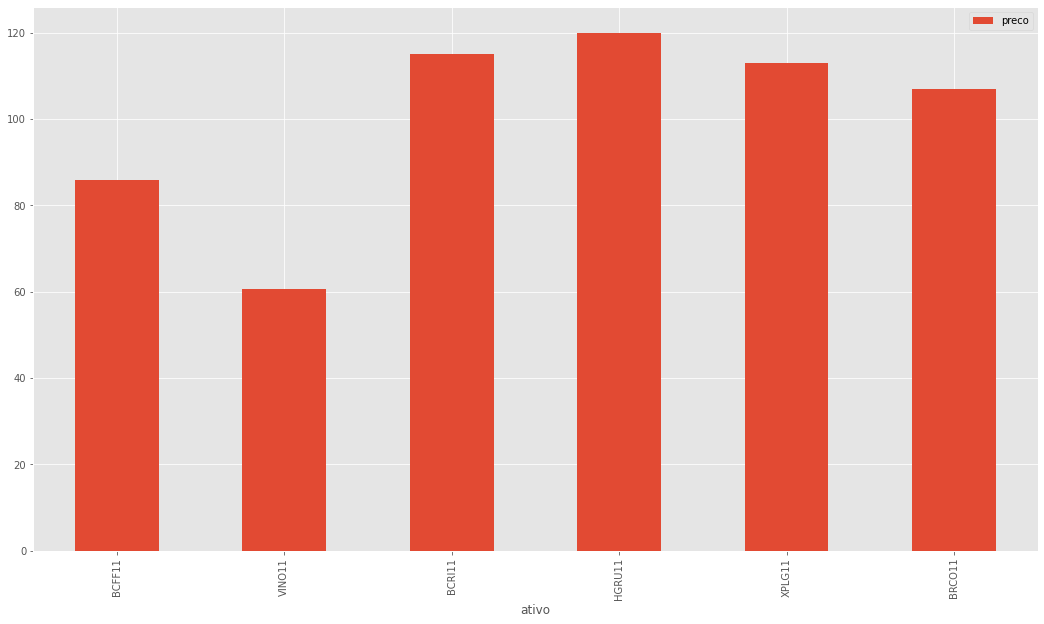

In [ ]:
df_union_data[['preco']].loc[['BCFF11', 'VINO11', 'BCRI11', 'HGRU11', 'XPLG11', 'BRCO11']].plot(figsize = (18, 10), grid=True, kind='bar')

In [103]:
df_results[['preco', 'dividendo', 'yeld', 'resultado_previsto']].loc[['BCFF11', 'VINO11', 'BCRI11', 'HGRU11', 'XPLG11', 'BRCO11']].sort_values(by=['yeld'], ascending=False)

,preco,dividendo,yeld,resultado_previsto
ativo,,,,
BCRI11,115.01,1.51,0.0127,2624.38
VINO11,60.66,0.45,0.0074,1483.65
BCFF11,85.82,0.50,0.0057,1165.00
HGRU11,119.99,0.68,0.0056,1132.88
XPLG11,113.01,0.60,0.0052,1061.40
BRCO11,106.99,0.54,0.0049,1009.26
